In [18]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D,
    UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, multiply,
    AveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import albumentations as A
from albumentations.core.composition import OneOf
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score, recall_score, jaccard_score
from medpy.metric.binary import hd 
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data split
base_path = 'D:/semester 6/skrpsi/breast cancer'
split_path = os.path.join(base_path, 'D:/semester 6/skrpsi/breast cancer/kode/data_split.pkl')
with open(split_path, 'rb') as f:
    X_train, X_val, y_train_cat, y_val_cat = pickle.load(f) 

In [3]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32) 
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, axis=-1)
        return tf.reduce_mean(loss)
    return loss

In [4]:
# Residual Block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), padding='same', kernel_initializer='he_normal')(shortcut)
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [5]:
# ASPP Block
def aspp(x, filters):
    shape = x.shape
    y1 = Conv2D(filters, 1, padding='same', dilation_rate=1, kernel_initializer='he_normal')(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)

    y2 = Conv2D(filters, 3, padding='same', dilation_rate=6, kernel_initializer='he_normal')(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)

    y3 = Conv2D(filters, 3, padding='same', dilation_rate=12, kernel_initializer='he_normal')(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)

    y4 = Conv2D(filters, 3, padding='same', dilation_rate=18, kernel_initializer='he_normal')(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)

    y5 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y5 = Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation='bilinear')(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [6]:
# SCSE Attention Block
def scse_block(x):
    channel = GlobalAveragePooling2D()(x)
    channel = Reshape((1,1,x.shape[-1]))(channel)
    channel = Conv2D(x.shape[-1]//2, 1, activation='relu', kernel_initializer='he_normal')(channel)
    channel = Conv2D(x.shape[-1], 1, activation='sigmoid', kernel_initializer='he_normal')(channel)
    x = multiply([x, channel])
    return x

In [7]:
# Build the full model
def build_model(input_shape=(256,256,3), num_classes=2):
    inputs = Input(input_shape)

    # Encoder
    x1 = residual_block(inputs, 32)
    p1 = MaxPooling2D((2,2))(x1)

    x2 = residual_block(p1, 64)
    p2 = MaxPooling2D((2,2))(x2)

    x3 = residual_block(p2, 128)
    p3 = MaxPooling2D((2,2))(x3)

    x4 = residual_block(p3, 256)
    p4 = MaxPooling2D((2,2))(x4)

    # Bottleneck with ASPP
    b = aspp(p4, 512)

    # Decoder
    u1 = UpSampling2D((2,2))(b)
    u1 = Concatenate()([u1, x4])
    u1 = residual_block(u1, 256)
    u1 = scse_block(u1)

    u2 = UpSampling2D((2,2))(u1)
    u2 = Concatenate()([u2, x3])
    u2 = residual_block(u2, 128)
    u2 = scse_block(u2)

    u3 = UpSampling2D((2,2))(u2)
    u3 = Concatenate()([u3, x2])
    u3 = residual_block(u3, 64)
    u3 = scse_block(u3)

    u4 = UpSampling2D((2,2))(u3)
    u4 = Concatenate()([u4, x1])
    u4 = residual_block(u4, 32)
    u4 = scse_block(u4)

    # Output
    output = Conv2D(num_classes, (1,1), activation='softmax')(u4)
    
    model = Model(inputs, output)
    return model



# Build model
model = build_model()

In [8]:
# Build model
model = build_model()

In [9]:
# Compile model
weights = np.array([1.0, 3.0]) 
model.compile(optimizer='adam', 
              loss=weighted_categorical_crossentropy(weights), 
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_22[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │        128 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 256, 256,  │          0 │ conv2d_39[0][0],  │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 256, 256,  │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_24[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128, 128,  │          0 │ conv2d_42[0][0],

 Total params: 9,834,514 (37.52 MB)

 Trainable params: 9,824,530 (37.48 MB)

 Non-trainable params: 9,984 (39.00 KB)

In [10]:
print(X_train.shape, y_train_cat.shape)
print(X_val.shape, y_val_cat.shape)

(517, 256, 256, 3) (517, 256, 256, 2)
(130, 256, 256, 3) (130, 256, 256, 2)


In [11]:
if y_train_cat.ndim == 1: 
    y_train = to_categorical(y_train_cat, num_classes=2)
    y_val = to_categorical(y_val_cat, num_classes=2)
else:
    y_train = y_train_cat
    y_val = y_val_cat

In [12]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("model output:", model.output_shape)

X_train: (517, 256, 256, 3)
y_train: (517, 256, 256, 2)
model output: (None, 256, 256, 2)


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_satu.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [14]:
# Train model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8833 - loss: 0.5147
Epoch 1: val_loss improved from inf to 2.24275, saving model to best_model_satu.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 289s 8s/step - accuracy: 0.8838 - loss: 0.5125 - val_accuracy: 0.8154 - val_loss: 2.2428
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9151 - loss: 0.3498
Epoch 2: val_loss improved from 2.24275 to 0.64351, saving model to best_model_satu.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.9151 - loss: 0.3500 - val_accuracy: 0.8894 - val_loss: 0.6435
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9217 - loss: 0.3013
Epoch 3: val_loss improved from 0.64351 to 0.55610, saving model to best_model_satu.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.9217 - loss: 0.3016 - val_accuracy: 0.8761 - val_loss: 0.5561
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9237 - loss: 0.3227
Epoch 4: val_loss did not improve from 0.55610
33/

In [15]:
print("Unique labels in masks:", np.unique(y_train))
print("Unique labels after one-hot encoding (y_train):", np.unique(np.argmax(y_train, axis=-1)))

Unique labels in masks: [0. 1.]
Unique labels after one-hot encoding (y_train): [0 1]


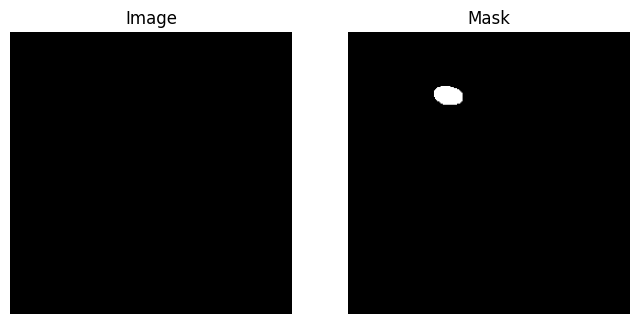

In [16]:
def plot_history(history):
    image = X_train[0]
    mask = np.argmax(y_train[0], axis=-1) 

    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(image.astype(np.uint8)) 
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()
    return image, mask

image, mask = plot_history(history)

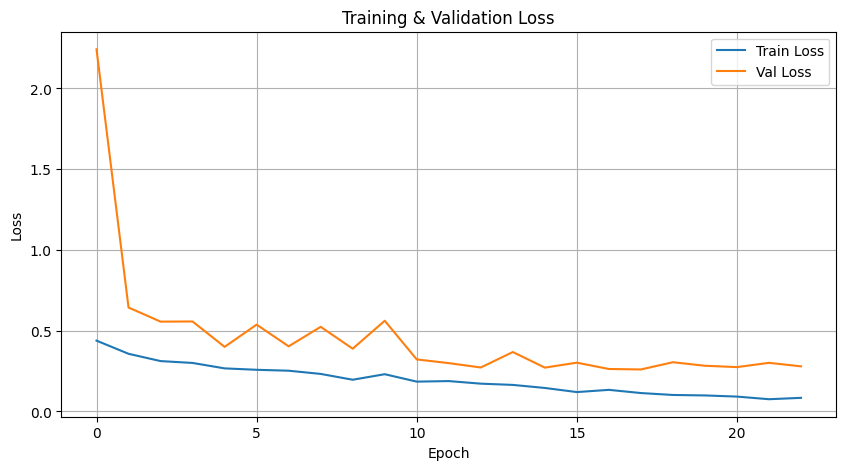

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Prediksi
y_pred = model.predict(X_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


In [20]:
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_val_argmax = np.argmax(y_val_cat, axis=-1)

In [21]:
def dice_score_per_class(y_true, y_pred, num_classes):
    smooth = 1e-6
    dice_scores = []
    for i in range(num_classes):
        y_true_i = (y_true == i).astype(np.float32)
        y_pred_i = (y_pred == i).astype(np.float32)
        intersection = np.sum(y_true_i * y_pred_i)
        dice = (2. * intersection + smooth) / (np.sum(y_true_i) + np.sum(y_pred_i) + smooth)
        dice_scores.append(dice)
    return dice_scores

In [22]:
# Hausdorff Distance per class
def hausdorff_distance(y_true, y_pred, num_classes):
    hausdorff = []
    for i in range(num_classes):
        y_true_i = (y_true == i).astype(np.uint8)
        y_pred_i = (y_pred == i).astype(np.uint8)
        try:
            h = hd(y_pred_i, y_true_i)
        except:
            h = np.nan  
        hausdorff.append(h)
    return hausdorff

In [23]:
print("y_val_argmax shape:", y_val_argmax.shape)
print("y_pred_argmax shape:", y_pred_argmax.shape)

print("y_train shape:", y_train_cat.shape)
print("y_val shape:", y_val_cat.shape)
print("Unique values in y_val[0]:", np.unique(y_val_cat[0]))

y_val_argmax shape: (130, 256, 256)
y_pred_argmax shape: (130, 256, 256)
y_train shape: (517, 256, 256, 2)
y_val shape: (130, 256, 256, 2)
Unique values in y_val[0]: [0. 1.]


In [24]:
assert y_val_argmax.shape == y_pred_argmax.shape, "Shape mismatch!"

In [25]:
# Evaluasi
num_classes = 2
dice = dice_score_per_class(y_val_argmax, y_pred_argmax, num_classes)
iou = [jaccard_score((y_val_argmax == i).flatten(), (y_pred_argmax == i).flatten()) for i in range(num_classes)]
precision = [precision_score((y_val_argmax == i).flatten(), (y_pred_argmax == i).flatten(), zero_division=0) for i in range(num_classes)]
recall = [recall_score((y_val_argmax == i).flatten(), (y_pred_argmax == i).flatten(), zero_division=0) for i in range(num_classes)]
hausdorff = hausdorff_distance(y_val_argmax, y_pred_argmax, num_classes)

In [27]:
# Hitung rata-rata
mean_dice = sum(dice) / num_classes
mean_iou = sum(iou) / num_classes
mean_precision = sum(precision) / num_classes
mean_recall = sum(recall) / num_classes
mean_hausdorff = sum(hausdorff) / num_classes

In [28]:
# Cetak hasil
print("Average Metrics:")
print(f"  Dice Score     : {mean_dice:.4f}")
print(f"  IoU            : {mean_iou:.4f}")
print(f"  Precision      : {mean_precision:.4f}")
print(f"  Recall         : {mean_recall:.4f}")
print(f"  Hausdorff Dist : {mean_hausdorff:.4f}")

Average Metrics:
  Dice Score     : 0.8372
  IoU            : 0.7409
  Precision      : 0.8021
  Recall         : 0.8867
  Hausdorff Dist : 43.7005


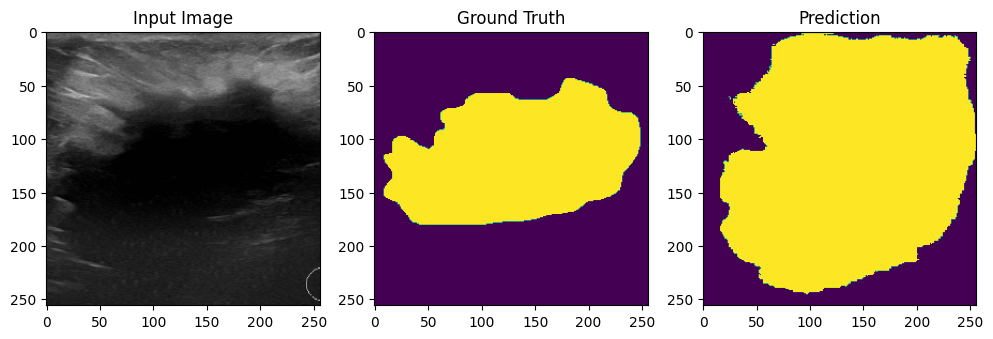

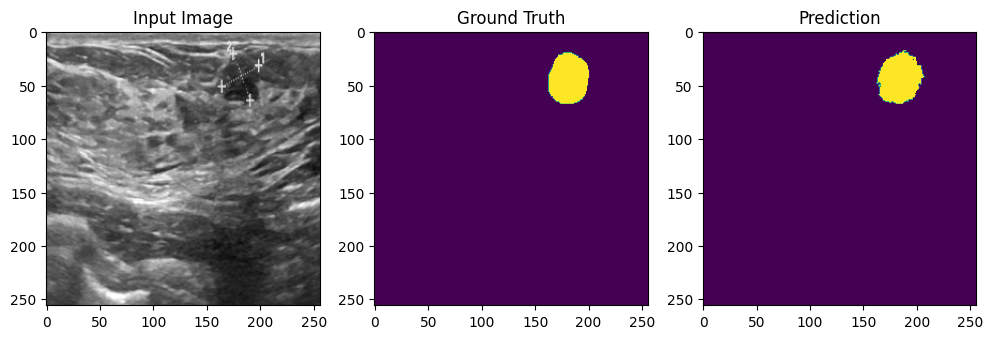

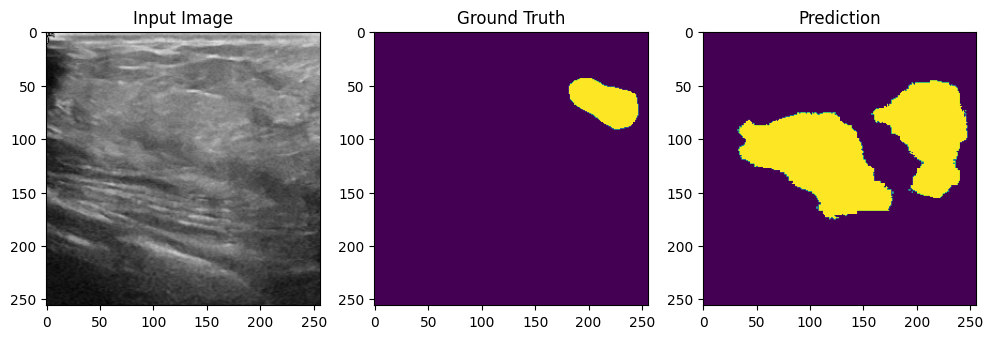

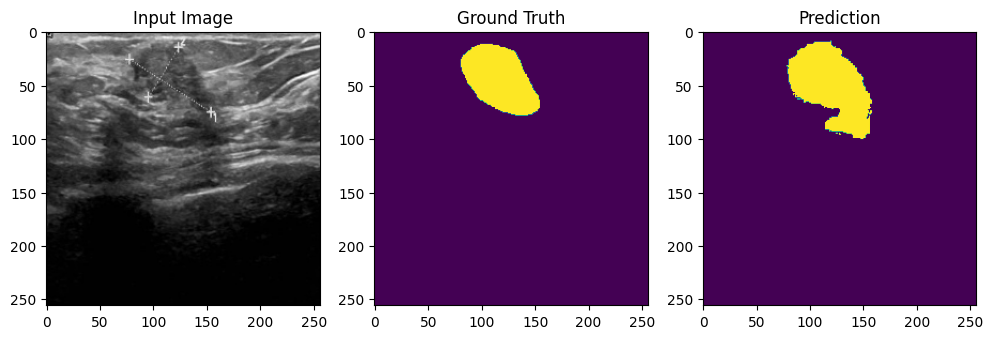

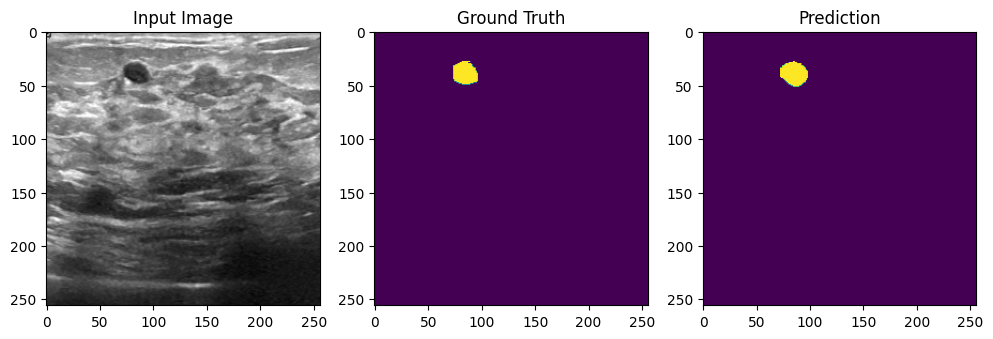

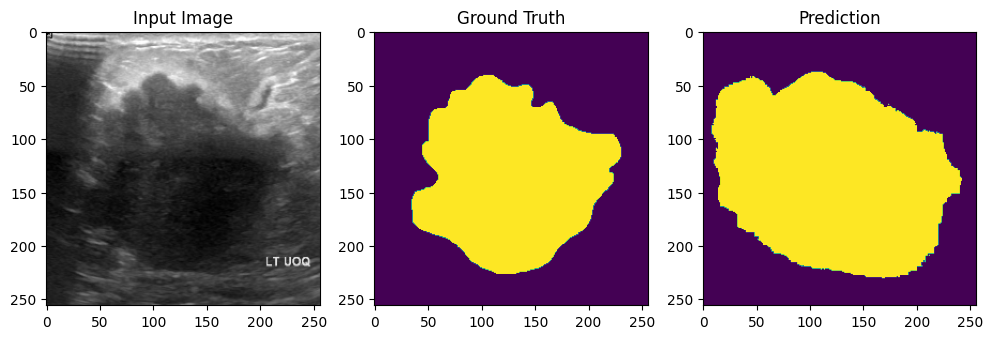

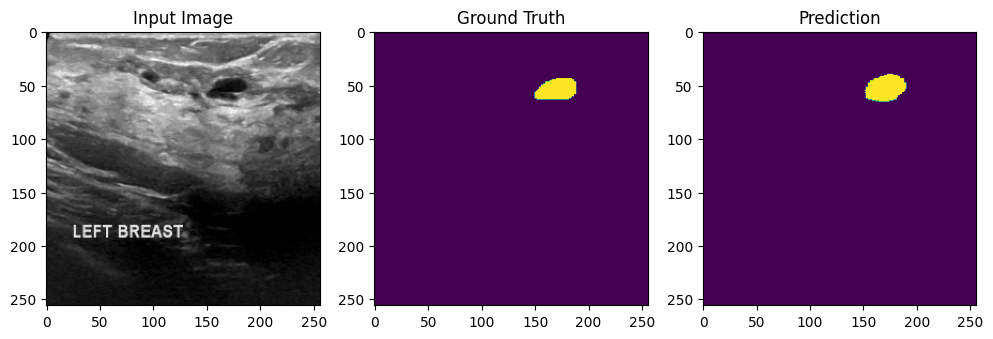

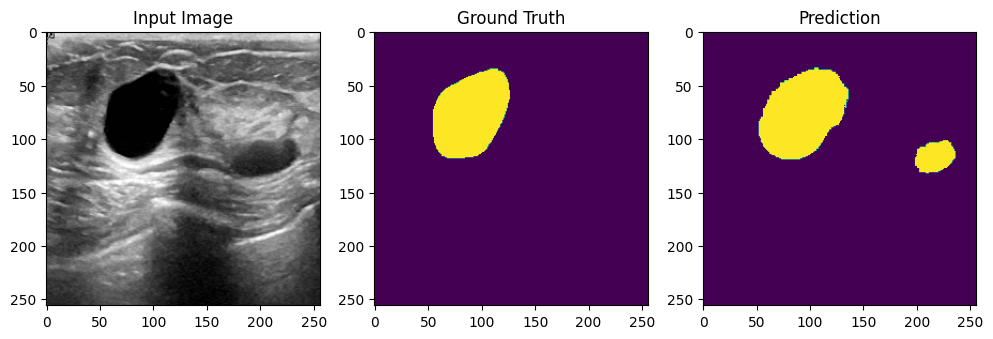

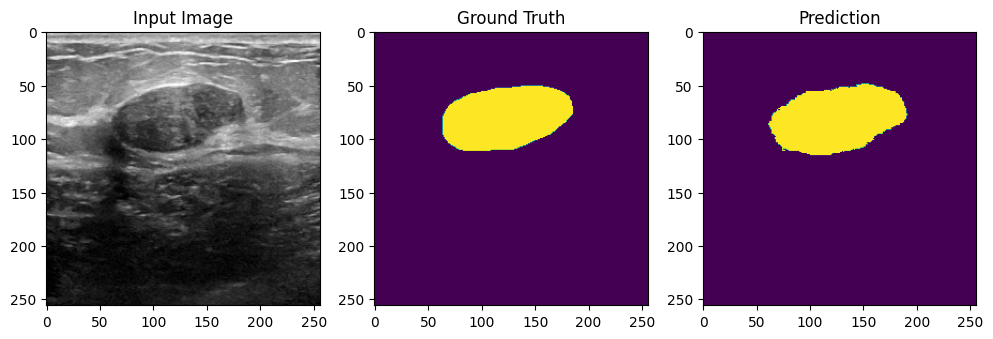

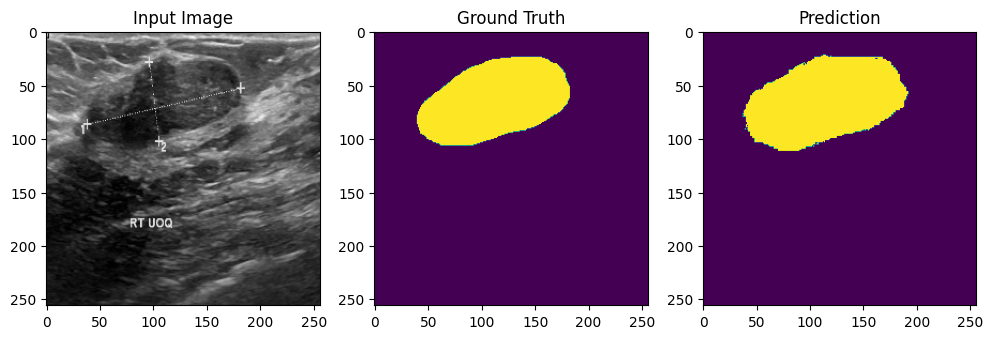

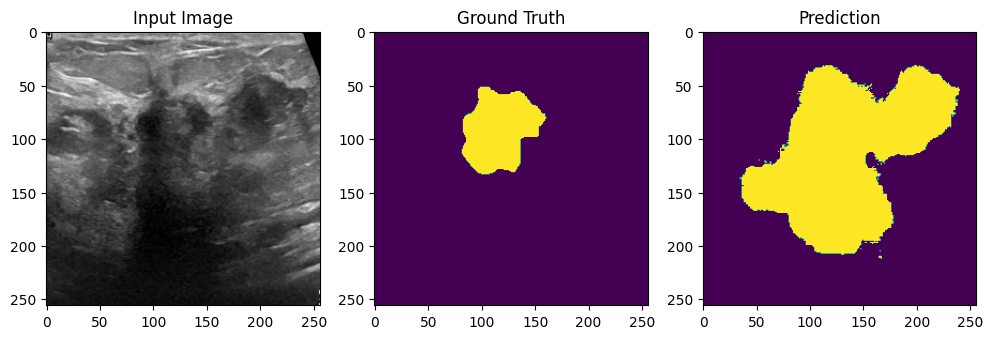

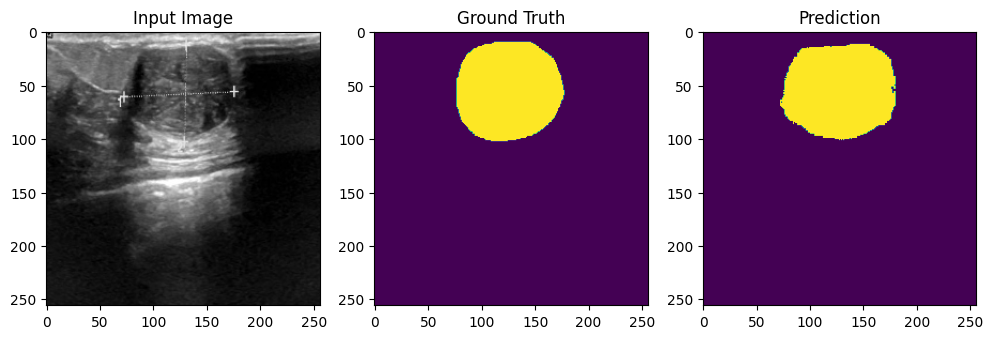

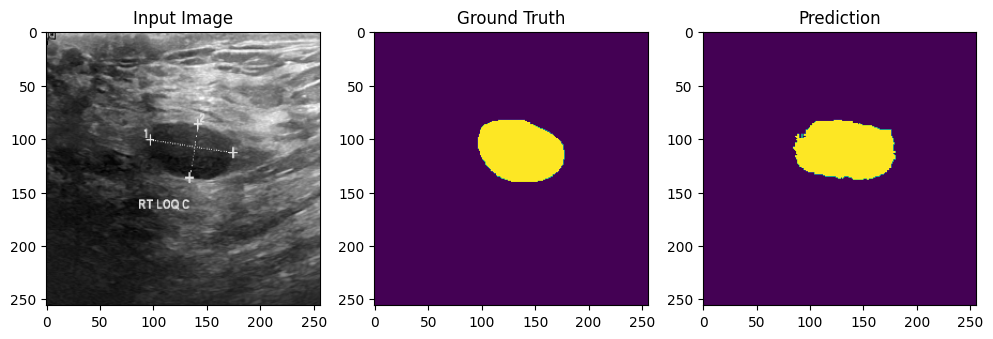

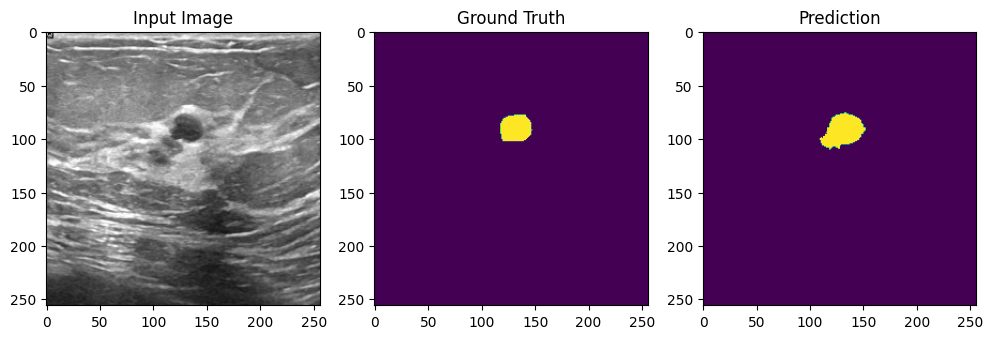

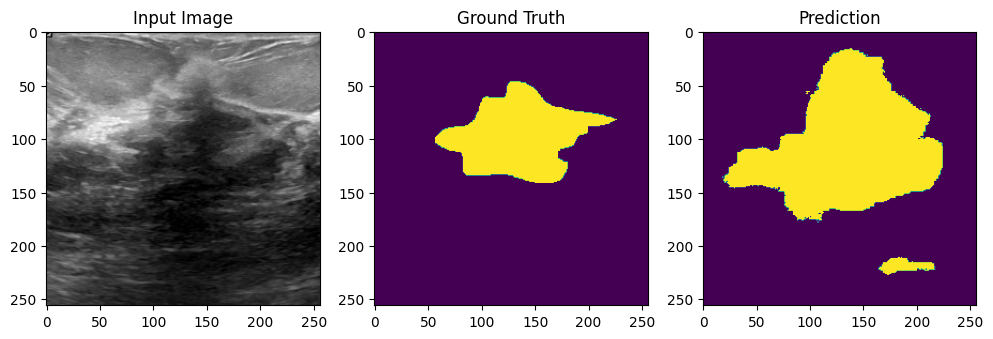

In [29]:
# Tampilkan 15 sampel
for i in range(15):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(X_val[i])
    
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(y_val_argmax[i])
    
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(y_pred_argmax[i])
    
    plt.show()